In [56]:
import ast

import networkx as nx
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [3]:
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")

In [4]:
accs = df_class1["account_address"].unique()
df_example_acc = df_class1[df_class1["account_address"] == accs[3]]
df_example_acc.head()

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount,error,...,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,to,type,effectiveGasPrice,logs,status
7,0f8010c8-0629-4888-bb65-6968d31ab8b9,2023-05-18 15:33:26.022925,0xfd0000000100069ad1670066004306009b487ad7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950628,0xcbf6ee3ac018650ab69a1690ed4e9f6122e644da0eb6...,6852621118464000000,5278844892422590574,-1573776226041409426,NaN,...,167718,NaN,167718,0,0x4f164C12934500ff43d61Db950CA7eCa53162604,0xFd0000000100069aD1670066004306009B487AD7,2,23393453389,[{'blockHash': '0x92f7ef79a9c961a02e8abc3d15ec...,1
8,d439b9c1-be19-484d-b71c-caa72e393990,2023-05-18 15:33:26.022925,0xfd0000000100069ad1670066004306009b487ad7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950628,0xf3d55cd917d7529dee15e8024a08d5fec3befa9e0a80...,5604963303892967229,7479782231899792812,1874818928006825583,NaN,...,151027,NaN,436891,2,0x4f164C12934500ff43d61Db950CA7eCa53162604,0xFd0000000100069aD1670066004306009B487AD7,2,1869942450103,[{'blockHash': '0x92f7ef79a9c961a02e8abc3d15ec...,1
71,bcd2ad55-8571-47f6-96cc-a1678f99d6b3,2023-05-18 15:41:15.413548,0xfd0000000100069ad1670066004306009b487ad7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950928,0x1032a9b7dd1f5b6b44afdf1a5cdc1a744997557765f1...,358107241557497084,364032006193621199,5924764636124115,NaN,...,178149,NaN,562234,4,0xECE773De275f2e57eD6eb537f8FDAce030F94601,0xFd0000000100069aD1670066004306009B487AD7,2,49973413351,[{'blockHash': '0x242f73ab241ea454a2c18caf048b...,1
129,7ea69d0c-a944-4d06-ab44-21d22f066ba7,2023-05-18 15:48:57.203959,0xfd0000000100069ad1670066004306009b487ad7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16951222,0xc4d972abafcccd875515f902827425d3e96373877e9d...,1026574092464825005,1075023390694709081,48449298229884076,NaN,...,147933,NaN,333203,1,0x66E0214592dC00993044F3c8dA5a61d166BCaF02,0xFd0000000100069aD1670066004306009B487AD7,2,311296721945,[{'blockHash': '0xb75d447a29994674e363277d40fe...,1
154,2de2c9ea-84de-4879-b2e7-390ab84d9023,2023-05-18 15:55:11.003549,0xfd0000000100069ad1670066004306009b487ad7,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16951482,0x1c620462496d3e4ed1440cf4ed1445e016efa4578424...,4716344928809839830,5962654688751843383,1246309759942003553,NaN,...,151039,NaN,454905,2,0xECE773De275f2e57eD6eb537f8FDAce030F94601,0xFd0000000100069aD1670066004306009B487AD7,2,266965754746,[{'blockHash': '0xdf922fb6df69e1849d95dbde7d22...,1


In [36]:
def extract_transfer_addresses(log):
    topics = log["topics"]
    ERC20_TRANSFER_SIG = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    if not topics:
        return None, None
    elif topics[0] != ERC20_TRANSFER_SIG:
        return None, None
    elif len(topics) < 3:
        return None, None
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address

In [45]:
sig_to_idx = {}
idx_counter = 0

def create_group_transaction_graph(group_df, label):
    global sig_to_idx, idx_counter
    group_account_mapping = {}
    node_counter = 0
    cumulative_edges = []
    cumulative_edge_attrs = []
    graphs = []
    
    # Iterate transactions within the group (growing cumulative graph)
    for _, row in group_df.iterrows():
        from_addr, to_addr = row["from"].lower(), row["to"].lower()
        if from_addr not in group_account_mapping:
            group_account_mapping[from_addr] = node_counter
            node_counter += 1
        if to_addr not in group_account_mapping:
            group_account_mapping[to_addr] = node_counter
            node_counter += 1
        cumulative_edges.append([group_account_mapping[from_addr], group_account_mapping[to_addr]])
        
        logs = ast.literal_eval(row["logs"])
        for log in logs:
            from_addr, to_addr = extract_transfer_addresses(log)
            if from_addr is None or to_addr is None:
                continue
            
            attr = []
            topic = log["topics"]
            if topic and topic[0] not in sig_to_idx:
                sig_to_idx[topic[0]] = idx_counter
                idx_counter += 1
            attr.append(sig_to_idx[topic[0]] if topic else -1)
            # raw_value = 0 if log["data"] == "0x" else int(log["data"], 16)
            # value = 0 if raw_value == 0 else safe_log(raw_value)
            # attr.append(value)
                
            # Retain the same node id for accounts that have already been seen
            if from_addr not in group_account_mapping:
                group_account_mapping[from_addr] = node_counter
                node_counter += 1
            if to_addr not in group_account_mapping:
                group_account_mapping[to_addr] = node_counter
                node_counter += 1
            cumulative_edges.append([group_account_mapping[from_addr], group_account_mapping[to_addr]])
            cumulative_edge_attrs.append(attr)

        # Build snapshot of cumulative graph up to this row
        num_nodes = node_counter
        degree = [0] * num_nodes
        for src, dst in cumulative_edges:
            degree[src] += 1
            degree[dst] += 1
        degree = torch.tensor(degree, dtype=torch.float).unsqueeze(1)
        edge_index_tensor = torch.tensor(cumulative_edges, dtype=torch.long).t().contiguous()
        edge_attr_tensor = torch.tensor(cumulative_edge_attrs, dtype=torch.int)
    
        y = torch.tensor(label, dtype=torch.int)
        trx_id = row["transaction_hash"]
    
        data = Data(x=degree, y=y, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor)
        # Copy the mapping to freeze the snapshot (so future updates don't affect this snapshot)
        data.account_mapping = group_account_mapping.copy()
        data.trx_id = trx_id
        graphs.append(data)
    
    return graphs

In [46]:
# Group transactions by the from_account and build graphs for each group.
grouped_data = []
for account, group_df in df_example_acc.groupby("account_address"):
    grouped_data.append(create_group_transaction_graph(group_df, 1))

In [47]:
grouped_data[0][0].trx_id

'0xcbf6ee3ac018650ab69a1690ed4e9f6122e644da0eb6a4b72b31a35b1bb991ec'

In [48]:
grouped_data[0][0].account_mapping

{'0x4f164c12934500ff43d61db950ca7eca53162604': 0,
 '0xfd0000000100069ad1670066004306009b487ad7': 1,
 '0xe34947aaaff202e2f08bd8b05f550b868c7383d4': 2,
 '0x844146b6a5318cacbc059505a42ff5f21afe9fa1': 3}

In [49]:
grouped_data[0][0].edge_index

tensor([[0, 1, 2, 1, 3],
        [1, 2, 1, 3, 1]])

In [50]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G, pos=nx.spring_layout(G, seed=42), with_labels=True, node_color=color, cmap="Set2"
    )
    # nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42))
    plt.show()

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


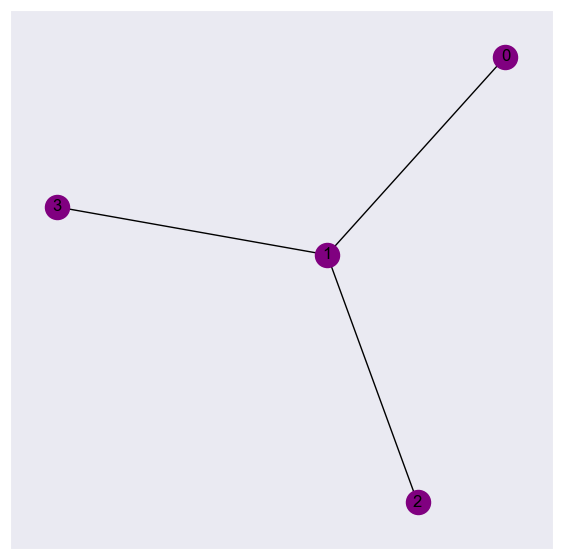

In [53]:
G = to_networkx(
        grouped_data[0][0],
        node_attrs=["x"],
        # edge_attrs=["edge_attr"],
        to_undirected=True,
    )
visualize_graph(G, color="purple")

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


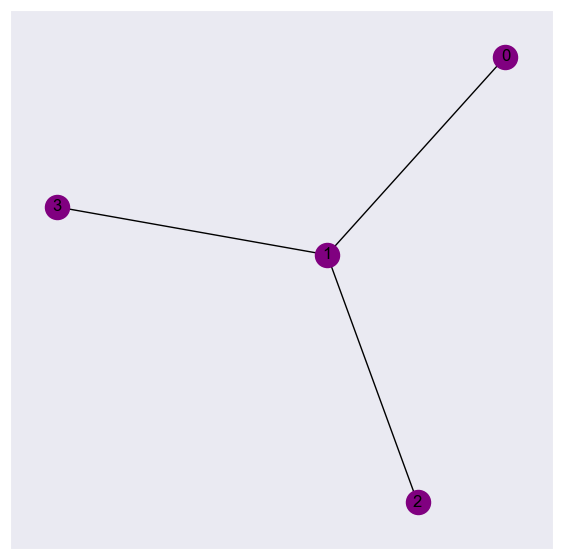

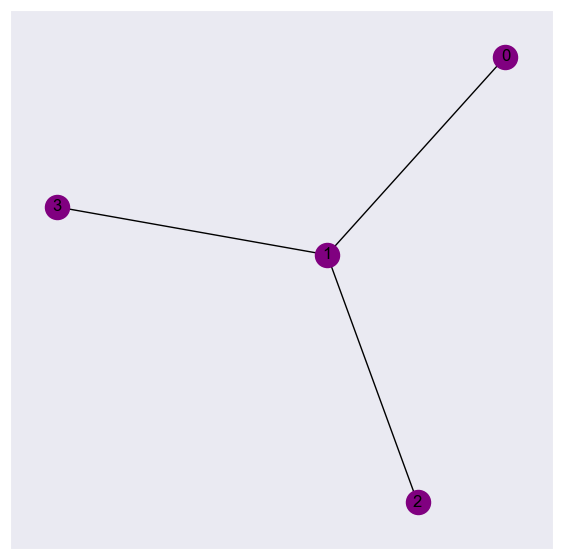

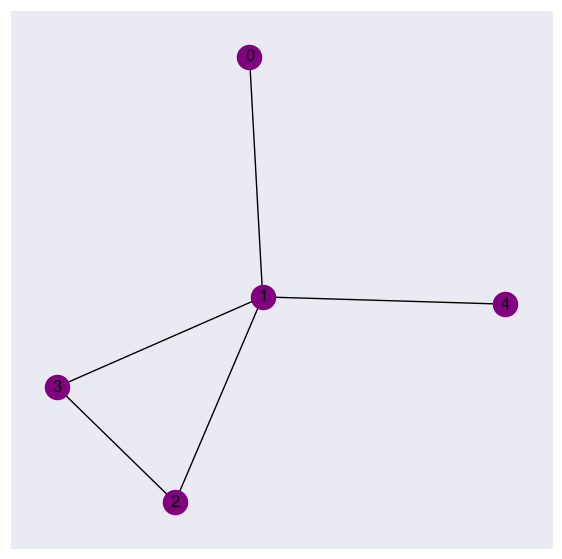

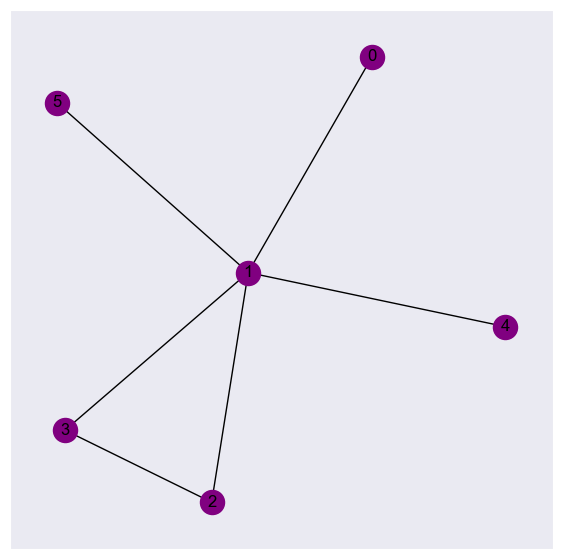

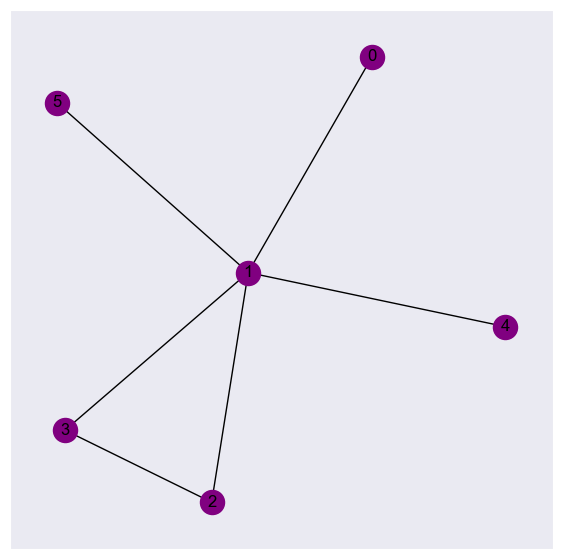

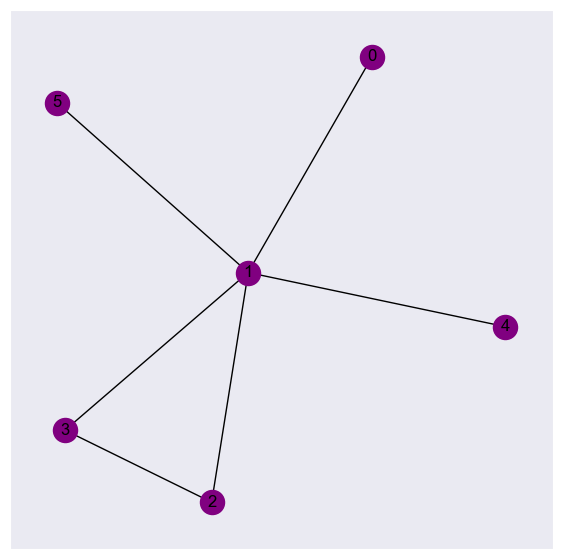

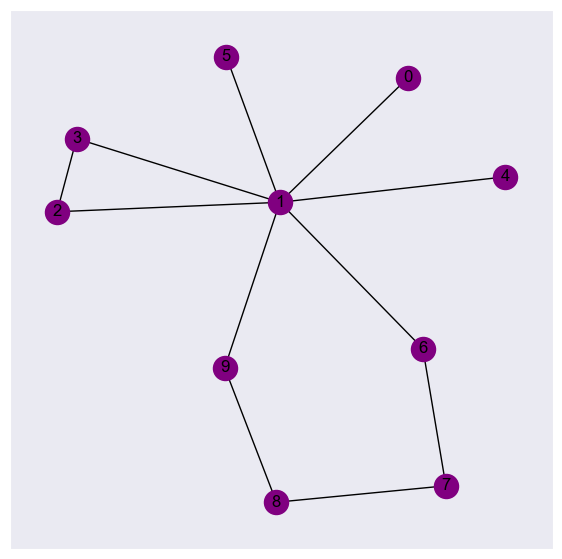

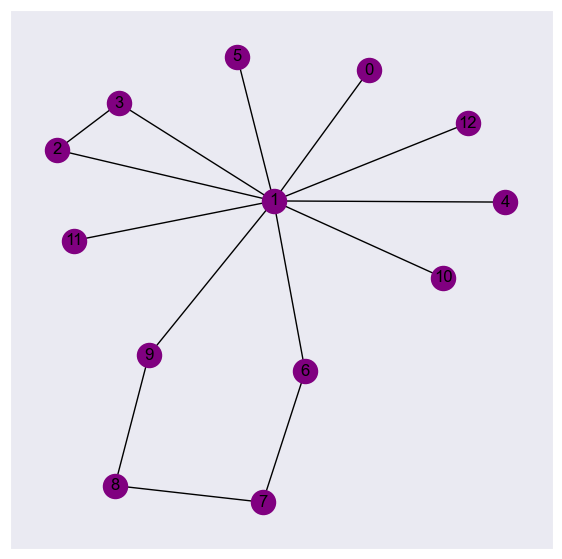

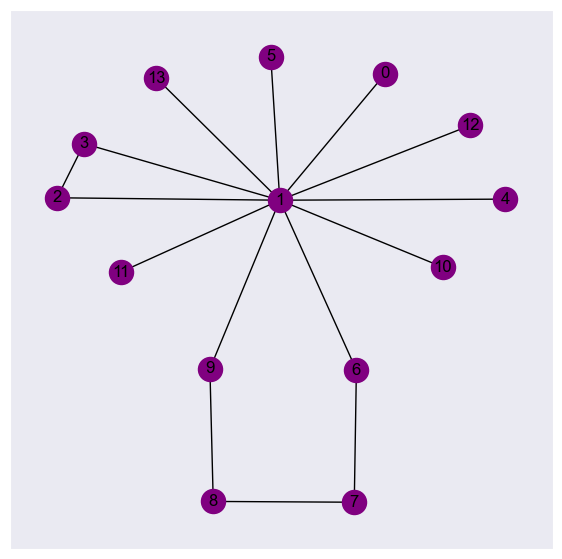

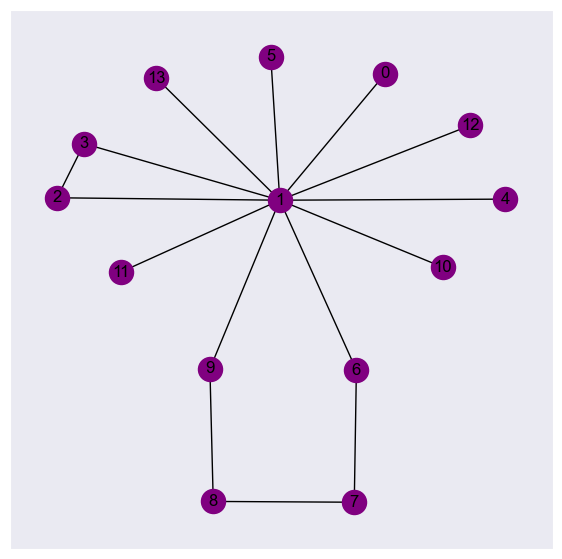

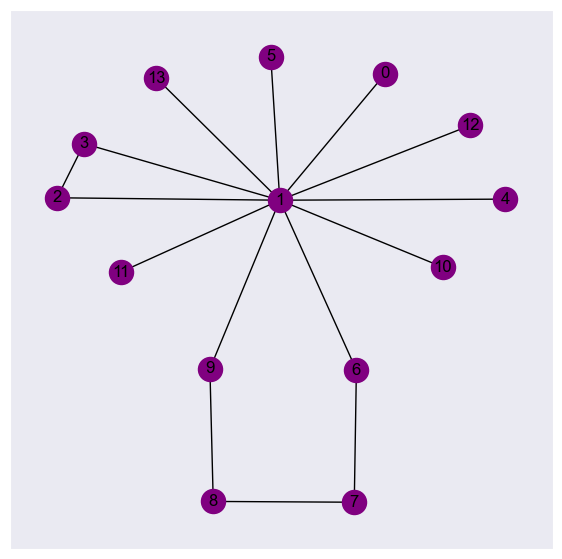

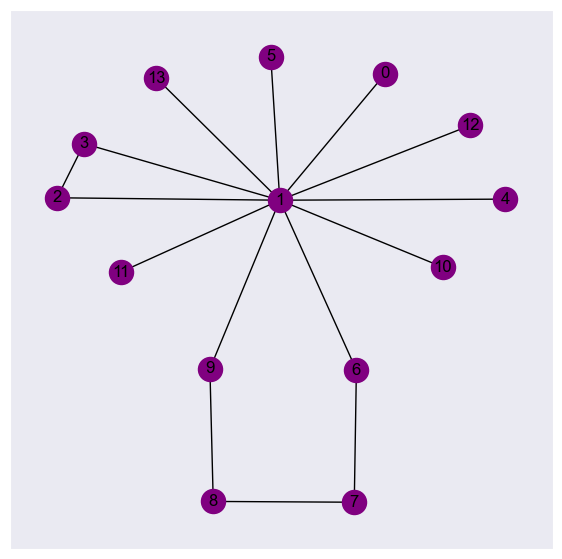

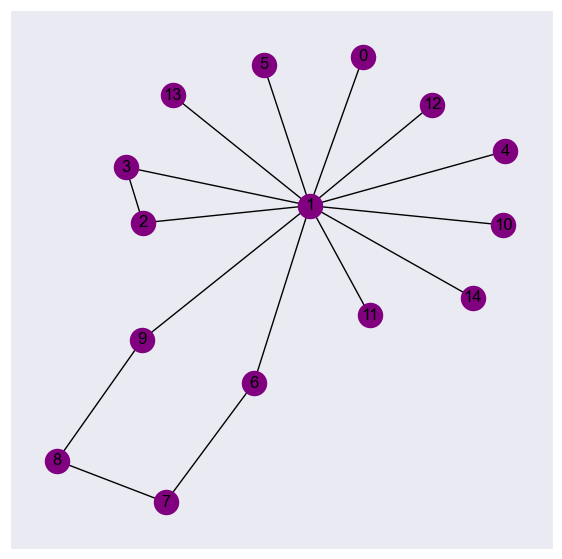

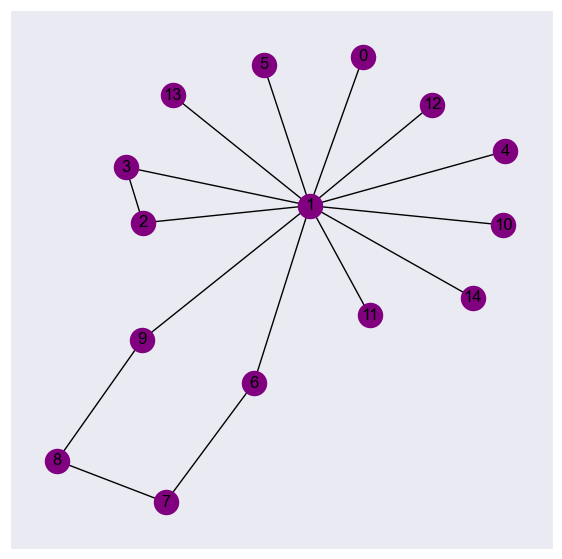

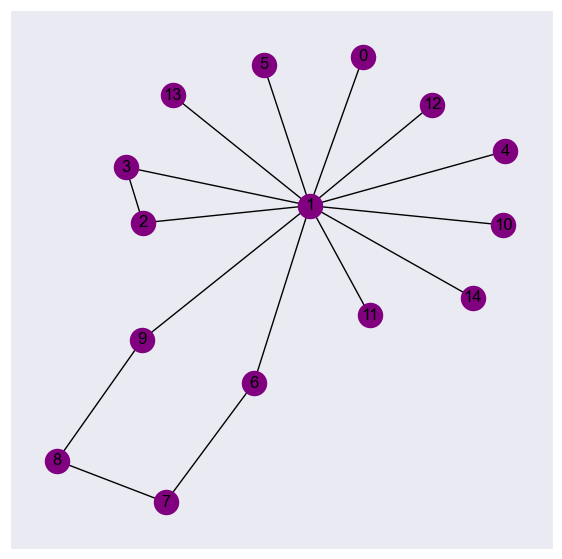

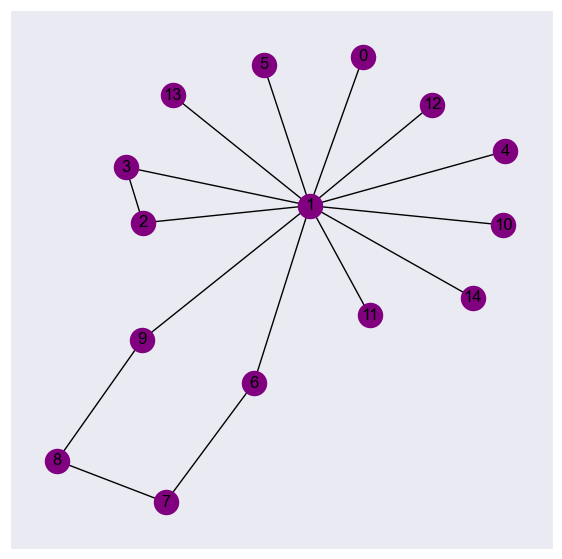

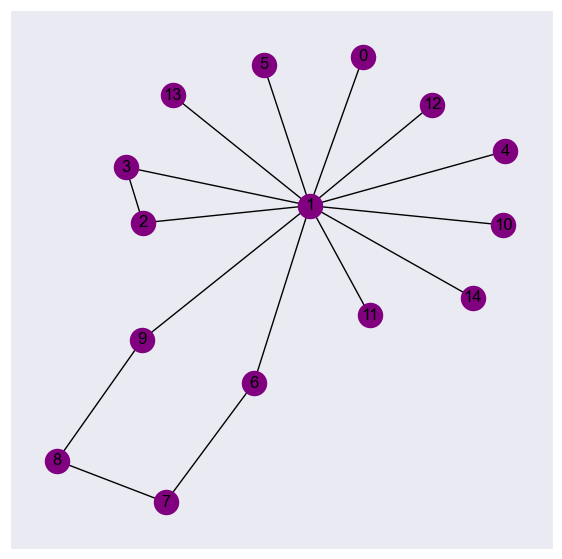

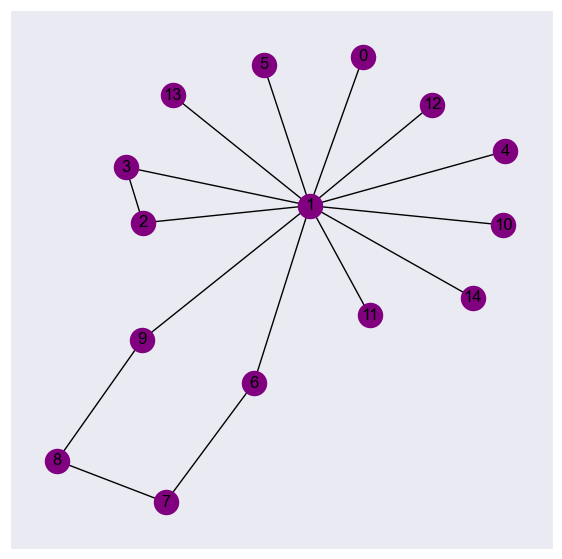

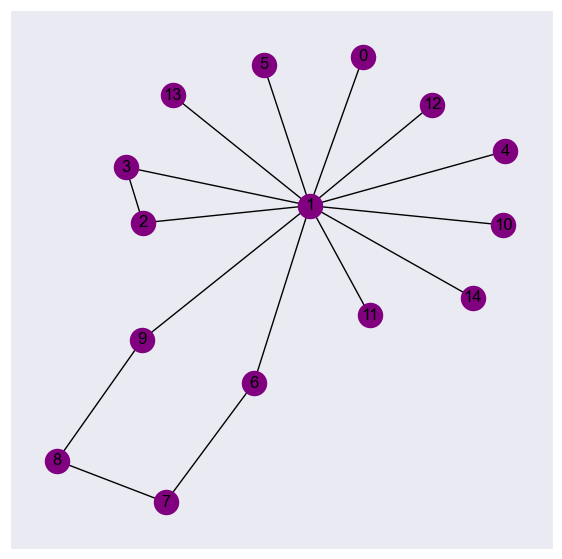

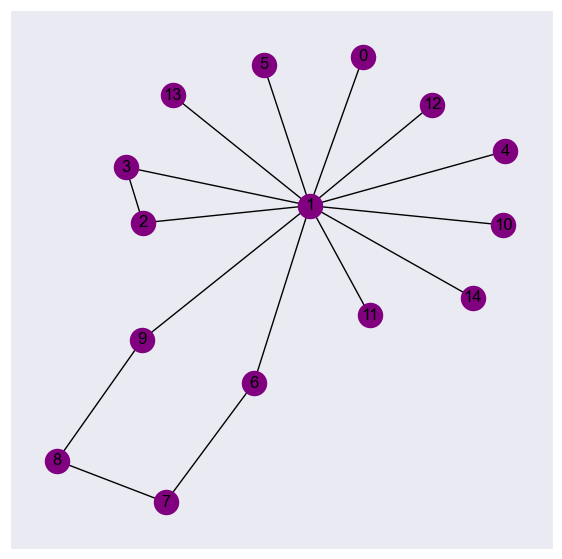

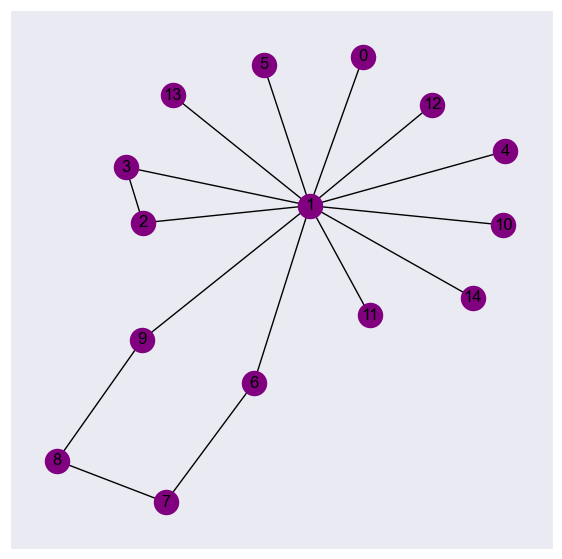

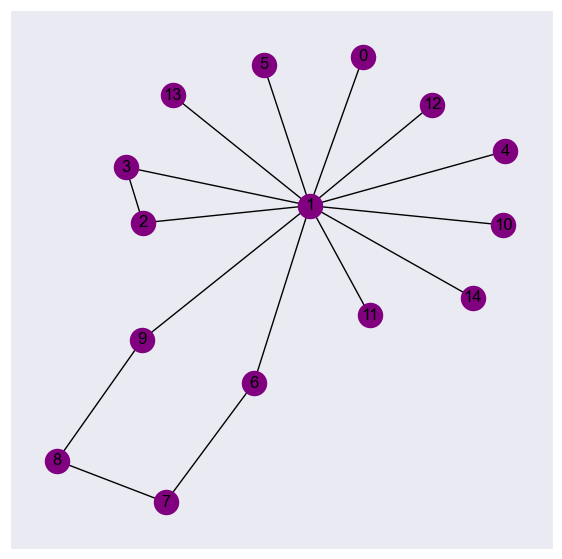

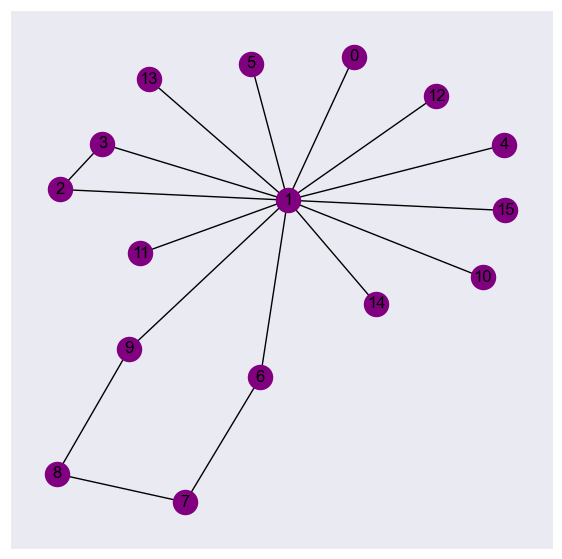

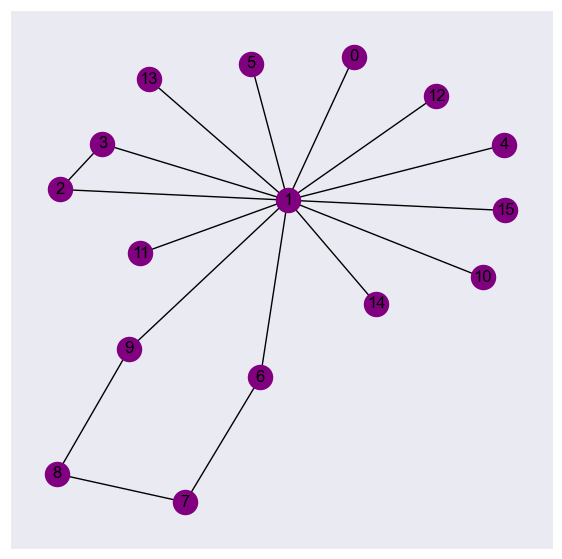

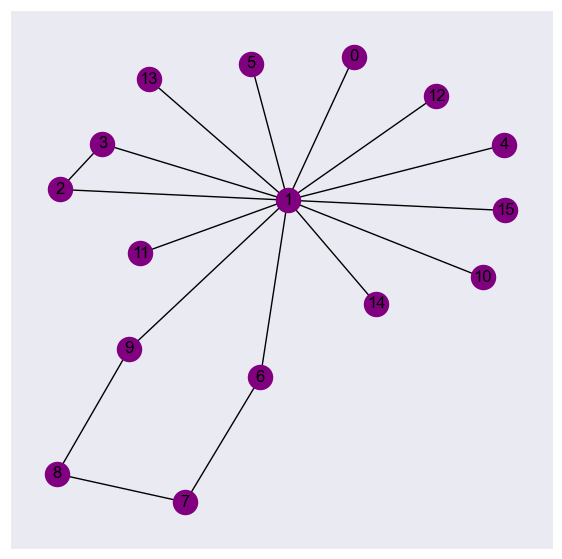

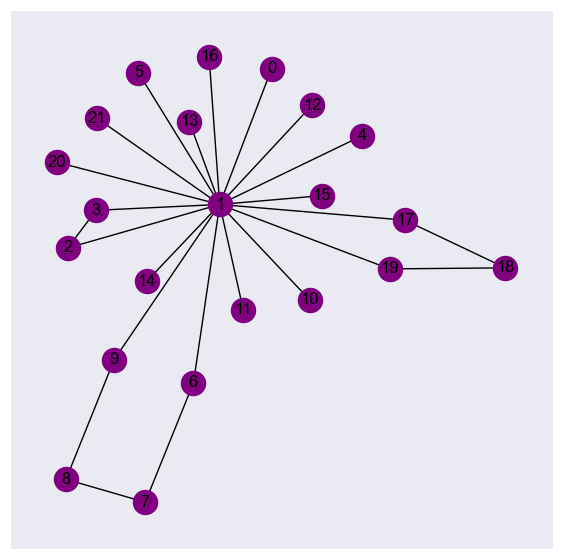

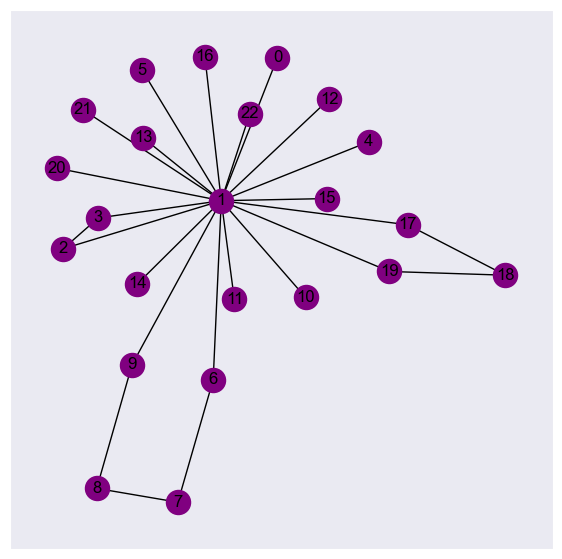

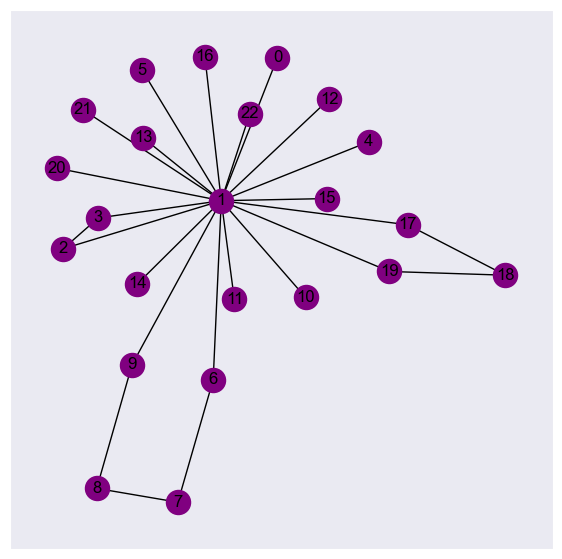

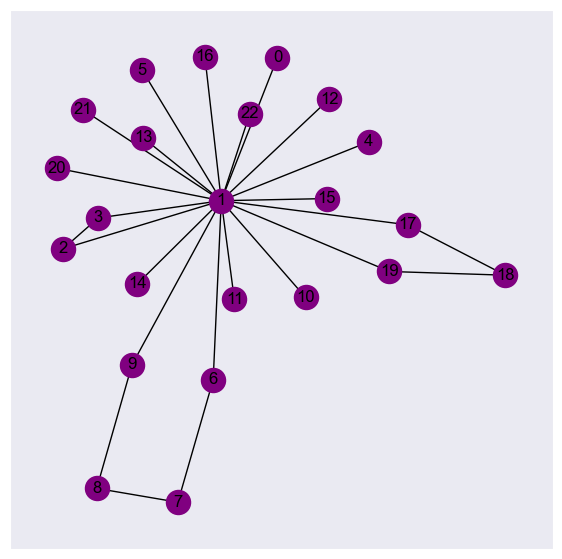

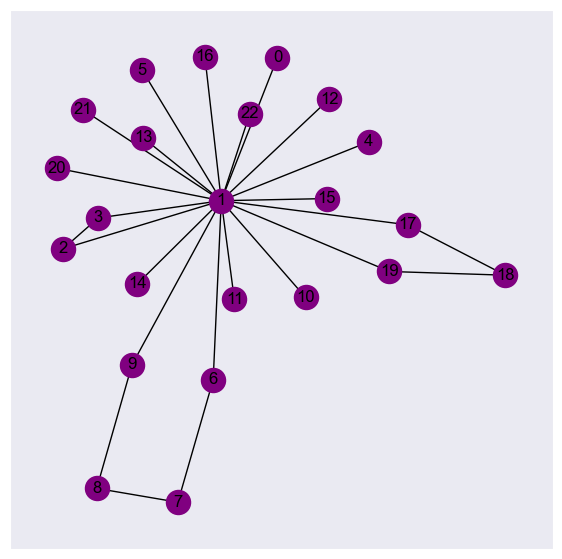

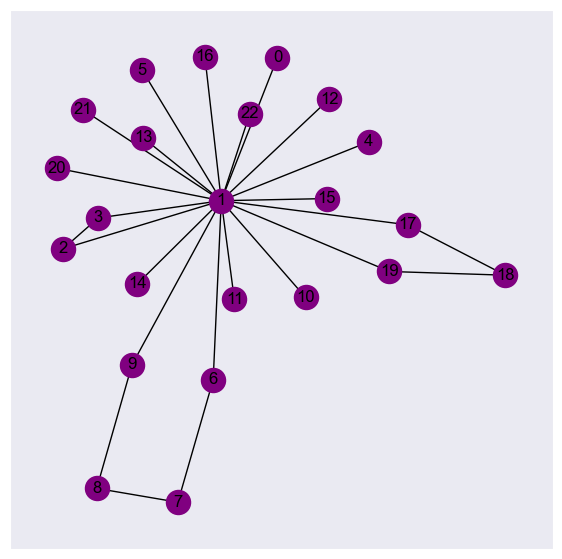

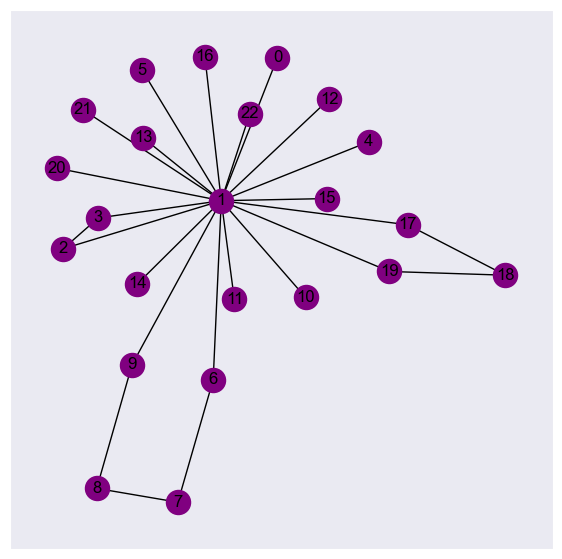

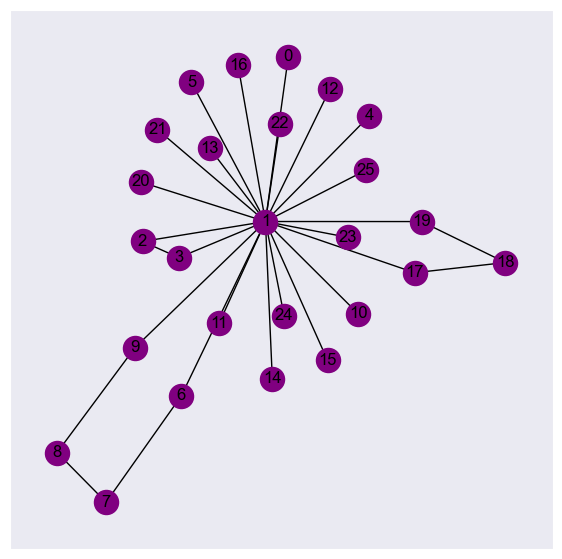

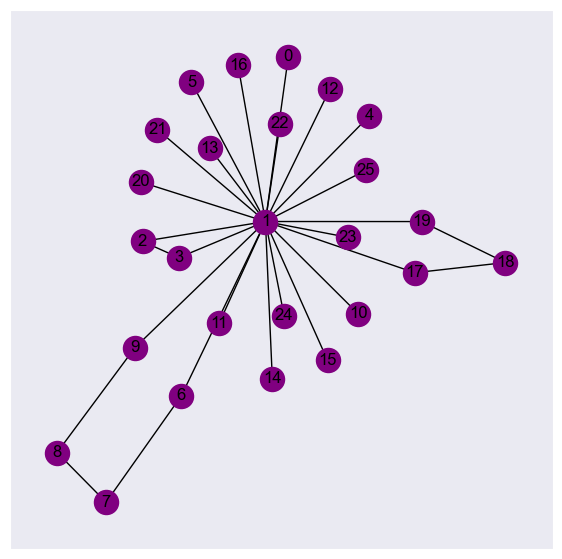

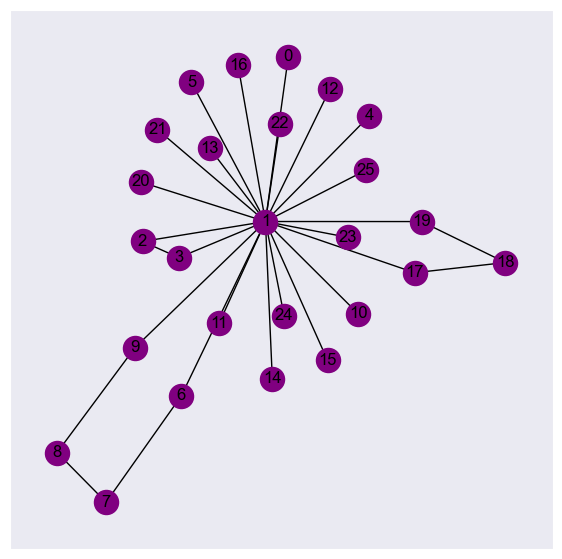

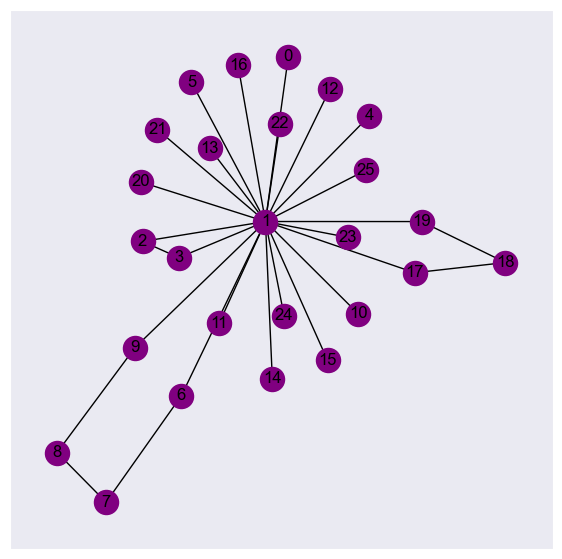

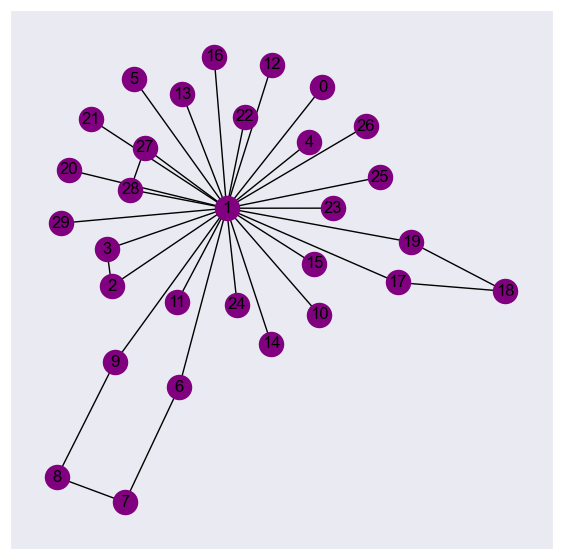

KeyboardInterrupt: 

<Figure size 700x700 with 0 Axes>

In [54]:
for d in grouped_data[0]:
    G = to_networkx(
        d,
        node_attrs=["x"],
        # edge_attrs=["edge_attr"],
        to_undirected=True,
    )
    visualize_graph(G, color="purple")

In [14]:
# torch.save(data, config.FLASHBOTS_Q2_DATA_DIR / "sthsth.pt")